# Physics-Informed Data-Driven Modeling in Python

## Part 1: Applying DMD with PyDMD

To ensure that you are working with the most recent version of PyDMD, we recommend that users install directly from the [Github source code](https://github.com/PyDMD/PyDMD). One can do so by running the following line of code:

In [1]:
# !pip install git+https://github.com/PyDMD/PyDMD

By the end of this section of the tutorial, users should be able to...
- Build and fit basic `BOPDMD` models (which implement optimized DMD with bagging).
- Access and understand crucial `DMD` model attributes.
- Visualize DMD results with the `plot_summary` function.

Run the following block of code to import packages and starter code.

In [2]:
# Be sure to install packages if needed.
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def compute_error(actual, truth):
    """
    Args:
        actual = numpy.ndarray of computed values
        truth = numpy.ndarray of expected values
    Returns:
        Relative error as a percentage
    """
    return 100 * np.linalg.norm(truth - actual) / np.linalg.norm(truth)

import warnings
warnings.filterwarnings("ignore")

We will apply DMD to a low resolution version of the fluid flow past a cylinder data set available online at [dmdbook.com/DATA.zip](dmdbook.com/DATA.zip). We will additionally work with a noisy version of the data set for added realism.

In [3]:
# Import vorticity data and frame dimensions.
mat = sio.loadmat("data/CYLINDER_ALL_LOW_RES.mat")

X = mat["VORTALL"]  # Vorticity data.
nx = mat["nx"][0][0]  # Number of pixels along x-axis.
ny = mat["ny"][0][0]  # Number of pixels along y-axis.
m = X.shape[-1]  # Number of time points.
t = np.arange(m)  # Time data.

print("Flow past a cylinder data loaded!")
print(f"X.shape (state, time) = {X.shape}")
print(f"t.shape (time,) = {t.shape}")
print(f"Time Discretization: [{t[0]}, {t[-1]}], dt = {np.round(t[1] - t[0], decimals=3)}")

# Add Gaussian noise to the data.
X_clean = X.copy()
noise_magnitude = 0.4
rng = np.random.default_rng(seed=1234)
noise = noise_magnitude * rng.standard_normal(X.shape)
X += noise

Flow past a cylinder data loaded!
X.shape (state, time) = (9834, 151)
t.shape (time,) = (151,)
Time Discretization: [0, 150], dt = 1


To give users a better sense of what this data set looks like, we provide the following animation of the data:

In [4]:
from IPython.display import Video
Video("data/cylinder.mp4")

We now apply DMD to this data set. Recall that for data in the form

$$
\mathbf{X} =
\begin{bmatrix}
| & | & & | \\
\mathbf{x}(t_1) &
\mathbf{x}(t_2) &
\dots &
\mathbf{x}(t_m) \\
| & | & & |
\end{bmatrix} \in \mathbb{R}^{n \times m},
$$

where we have $m$ snapshots of $n$-dimensional data, the DMD algorithm seeks the following decomposition:

$$
\mathbf{X}
\approx
\begin{bmatrix}
    | & & | \\
    \boldsymbol{\phi}_1 & \dots & \boldsymbol{\phi}_r \\
    | & & |
\end{bmatrix}
\begin{bmatrix}
    b_1 \\ & \ddots \\ && b_r
\end{bmatrix}
\begin{bmatrix}
    e^{\omega_1 t_1} & \dots & e^{\omega_1 t_m} \\
    \vdots & \ddots & \vdots \\
    e^{\omega_r t_1} & \dots & e^{\omega_r t_m}
\end{bmatrix}
= \mathbf{\Phi} \text{diag}(\mathbf{b})\mathbf{T}(\boldsymbol{\omega}),
$$

where the columns of $\mathbf{\Phi}$ give spatial modes, the entries of $\boldsymbol{\omega}$ give corresponding temporal frequencies, and the entries of $\mathbf{b}$ give mode amplitudes which signify the strength or importance of a spatiotemporal mode.

In practice, we apply DMD by using the [Optimized DMD](https://epubs.siam.org/doi/10.1137/M1124176) algorithm. This is because the algorithm is extremely robust to measurement noise, and the algorithm can accept unevenly-sampled snapshots, eigenvalue constraints, etc. This algorithm is implemented by the `BOPDMD` module, which is a reference to the even more advanced bagging optimized DMD algorithm (BOP-DMD).

To utilize this algorithm, simply build a `BOPDMD` model and invoke the `fit` method, which requires the data snapshots $\mathbf{X}$ and the times of data collection $\mathbf{t}$. We demonstrate this process below. Notice that we use `svd_rank=11` in order to tell PyDMD that we want to build a model with 11 modes total.

In [5]:
from pydmd import BOPDMD

# Build an Optimized DMD model with 11 spatiotemporal modes.
dmd = BOPDMD(svd_rank=11)

# Fit the Optimized DMD model.
dmd.fit(X, t)

### **Exercise 1:**

Print the shape of the `modes` and `dynamics` attributes of our fitted `DMD` model.

Note that the `modes` attribute contains the entries of $\mathbf{\Phi}$, while the `dynamics` attribute contains the entries of $\mathbf{T}(\boldsymbol{\omega})$, but scaled by their appropriate amplitude from $\mathbf{b}$.

- How do these shapes relate to the `svd_rank` and the dimensions of the input data?

In [6]:
print(dmd.modes.shape)
print(dmd.dynamics.shape)

(9834, 11)
(11, 151)


### **Exercise 2:**

Now let's get an idea of what exactly the modes and dynamics tell us about the data.

To do so, start by plotting the first 4 columns of `modes` and the first 4 rows of `dynamics`.

You will find that the columns of `modes` capture spatial features of the data and hence share the same dimensions as our input data snapshots. Conversely, the rows of `dyanmics` are time trajectories, where the ith time trajectory shows how the intensity of the ith spatial mode varies across time. Combined, these spatial mode time dynamic pairs form what we call _spatiotemporal modes_.

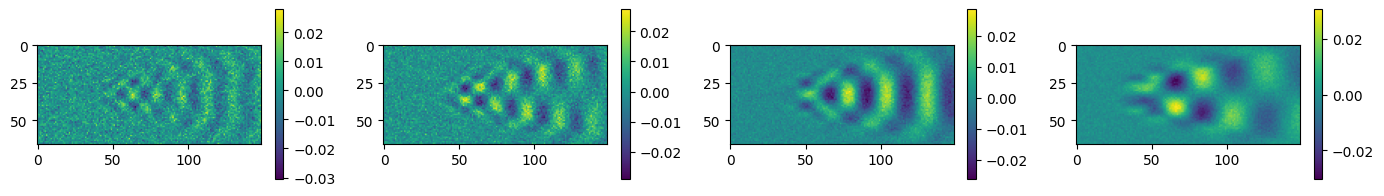

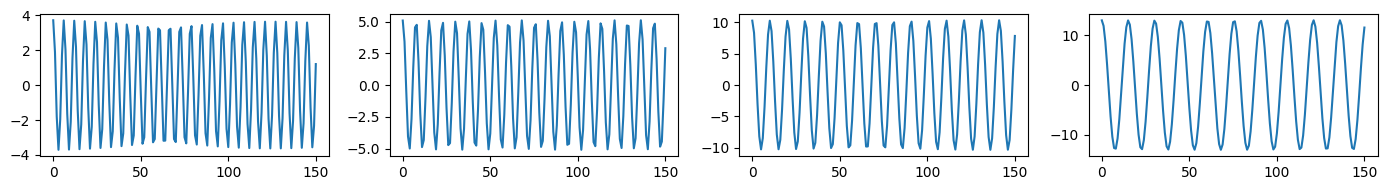

In [7]:
# Indices to plot.
index_plot = np.arange(4)

# Plot the modes.
plt.figure(figsize=(14, 2))
for i, idx in enumerate(index_plot):
    plt.subplot(1, 4, i + 1)
    plt.imshow(dmd.modes[:, idx].real.reshape(nx, ny, order="F"))
    plt.colorbar()
plt.tight_layout()
plt.show()

# Plot the dynamics.
plt.figure(figsize=(14, 2))
for i, idx in enumerate(index_plot):
    plt.subplot(1, 4, i + 1)
    plt.plot(t, dmd.dynamics[idx].real)
plt.tight_layout()
plt.show()

### **Exercise 3:**

Print the `amplitudes` attribute of our fitted `BOPDMD` model.

This attribute contains the learned mode amplitudes $\mathbf{b}$.

- Based on these values, which indices correspond with the most prominent spatiotemporal modes?

In [8]:
print(dmd.amplitudes)

[ 3.71974032  5.07656813 10.24570088 12.99175627 93.49182945 34.98018113
  3.71974032  5.07656813 10.24570088 34.98018113 12.99175627]


### **Exercise 4:**

Repeat Exercise 2, only this time, plot the modes and dynamics that correspond with the 4 largest entries of `amplitudes`. In doing so, you are visualizing the 4 spatiotemporal modes that contribute the most to the input data.

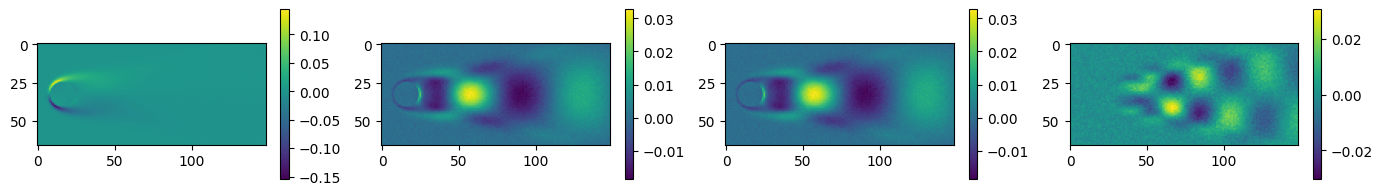

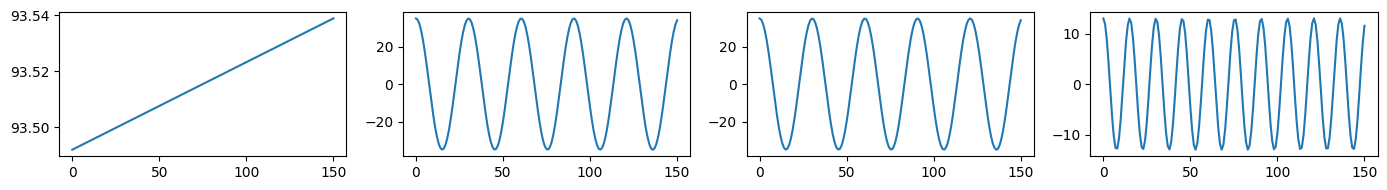

In [9]:
# Indices to plot.
index_plot = np.argsort(-dmd.amplitudes)[:4]

# Plot the modes.
plt.figure(figsize=(14, 2))
for i, idx in enumerate(index_plot):
    plt.subplot(1, 4, i + 1)
    plt.imshow(dmd.modes[:, idx].real.reshape(nx, ny, order="F"))
    plt.colorbar()
plt.tight_layout()
plt.show()

# Plot the dynamics.
plt.figure(figsize=(14, 2))
for i, idx in enumerate(index_plot):
    plt.subplot(1, 4, i + 1)
    plt.plot(t, dmd.dynamics[idx].real)
plt.tight_layout()
plt.show()

When added all together, the sum of all of the computed spatiotemporal modes forms our estimate of the training data set. Although we could compute and add up these modes ourselves, PyDMD already does this. Fitted PyDMD models possess a `reconstructed_data` attribute, which uses the computed DMD diagnostics in order to attempt to reconstruct the data. Below, we print the reconstruction error that results from our fit.

We additionally provide an animation of the DMD reconstruction.

In [10]:
# Reconstruction error on the clean data set:
print(f"DMD reconstruction error: {compute_error(dmd.reconstructed_data, X_clean)}%")
Video("data/cylinder_recon.mp4")

DMD reconstruction error: 9.984436120787116%


### **Exercise 5:**

Print the `eigs` attribute of our fitted `BOPDMD` model.

This attribute contains the learned frequency components $\omega$.

These are also sometimes referred to as the "continuous-time eigenvalues".

In [11]:
print(dmd.eigs)

[-1.75415412e-04+1.03898357e+00j  3.78361167e-05+8.31312067e-01j
  4.84173032e-05+6.23569952e-01j  1.30452137e-05+4.15680859e-01j
  3.35450460e-06+3.55851822e-21j  1.40896960e-05+2.07824529e-01j
 -1.75415412e-04-1.03898357e+00j  3.78361167e-05-8.31312067e-01j
  4.84173032e-05-6.23569952e-01j  1.40896960e-05-2.07824529e-01j
  1.30452137e-05-4.15680859e-01j]


Since printing these values isn't the most informative, alternatively visualize these values by plotting them in the complex plane. `pydmd.plotter` contains the function `plot_eigs` that can do this for you.

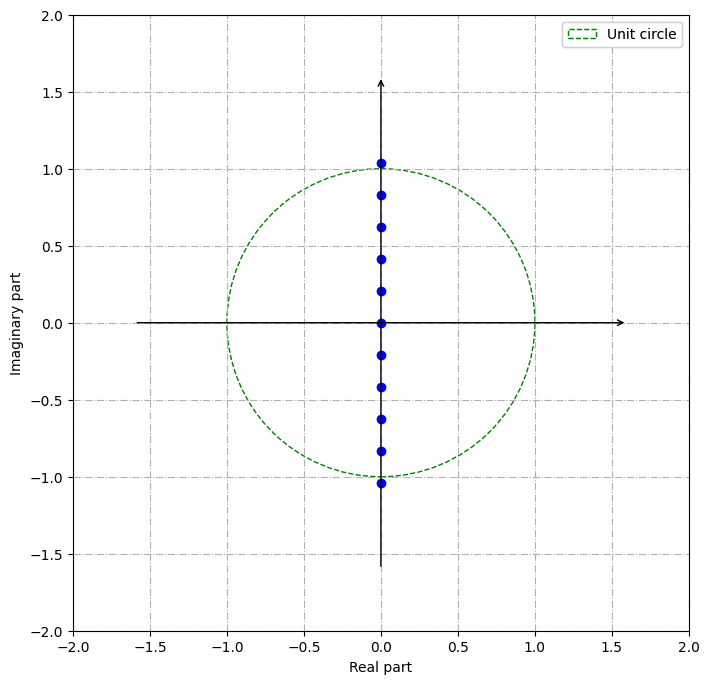

In [12]:
from pydmd.plotter import plot_eigs
plot_eigs(dmd)

These are the values that parameterize the time dynamics matrix.

To see how they relate to the time dynamics trajectories, try plotting cosine functions whose frequencies are determined by the imaginary component of the eigenvalues. You will see that this yields oscillatory dynamics whose frequencies match those of the time dynamics.

Notice that in this particular application, these eigenvalues are all roughly imaginary, and they come in complex conjugate pairs. We won't dive too much into the details, but it suffices to say that this in indicative of how this data set consists of spatial modes that are almost **purely oscillatory**. That is, our modes roughly do _not_ grow or decay overall over time -- they simply oscillate. Take not of this. We will come back to it.

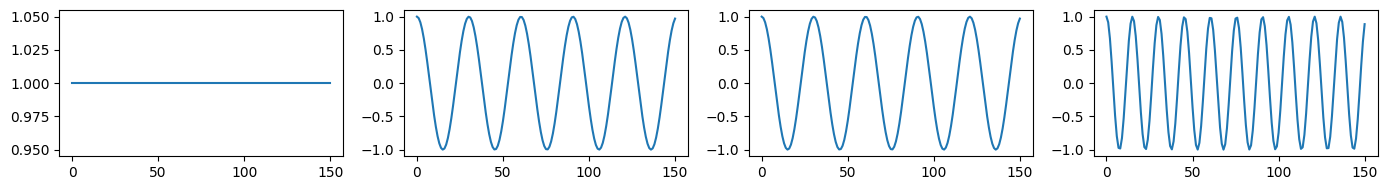

In [13]:
# Indices to plot.
index_plot = np.argsort(-dmd.amplitudes)[:4]

# Plot the "dynamics".
plt.figure(figsize=(14, 2))
for i, idx in enumerate(index_plot):
    plt.subplot(1, 4, i + 1)
    plt.plot(t, np.cos(dmd.eigs[idx].imag * t))
plt.tight_layout()
plt.show()

### **Wrapping up!**

We have now examined all of the key components of the DMD representation. Nice!

However, instead of grabbing all of these attributes individually, you can visualize all of these attributes at once with a simple call to the `plot_summary` function found in the `pydmd.plotter` suite. We demonstrate a simple call to this function below. Note that the function requires a fitted PyDMD model, along with any necessary or relevant plotting parameters. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/plotter.py#L537)

Notice that on top of plotting our eigenvalues, modes, and dynamics, `plot_summary` also gives us the following:
- The singular value spectrum of the data matrix $\mathbf{X}$ is provided. From this, we can tell that this data requires a decomposition with at least $r = 9$.
- Eigenvalues, modes, and dynamics are color-coordinated to indicate the pairings that make up each spatiotemporal mode.
- Eigenvalue marker sizes reflect the corresponding amplitude of the spatiotemporal mode.

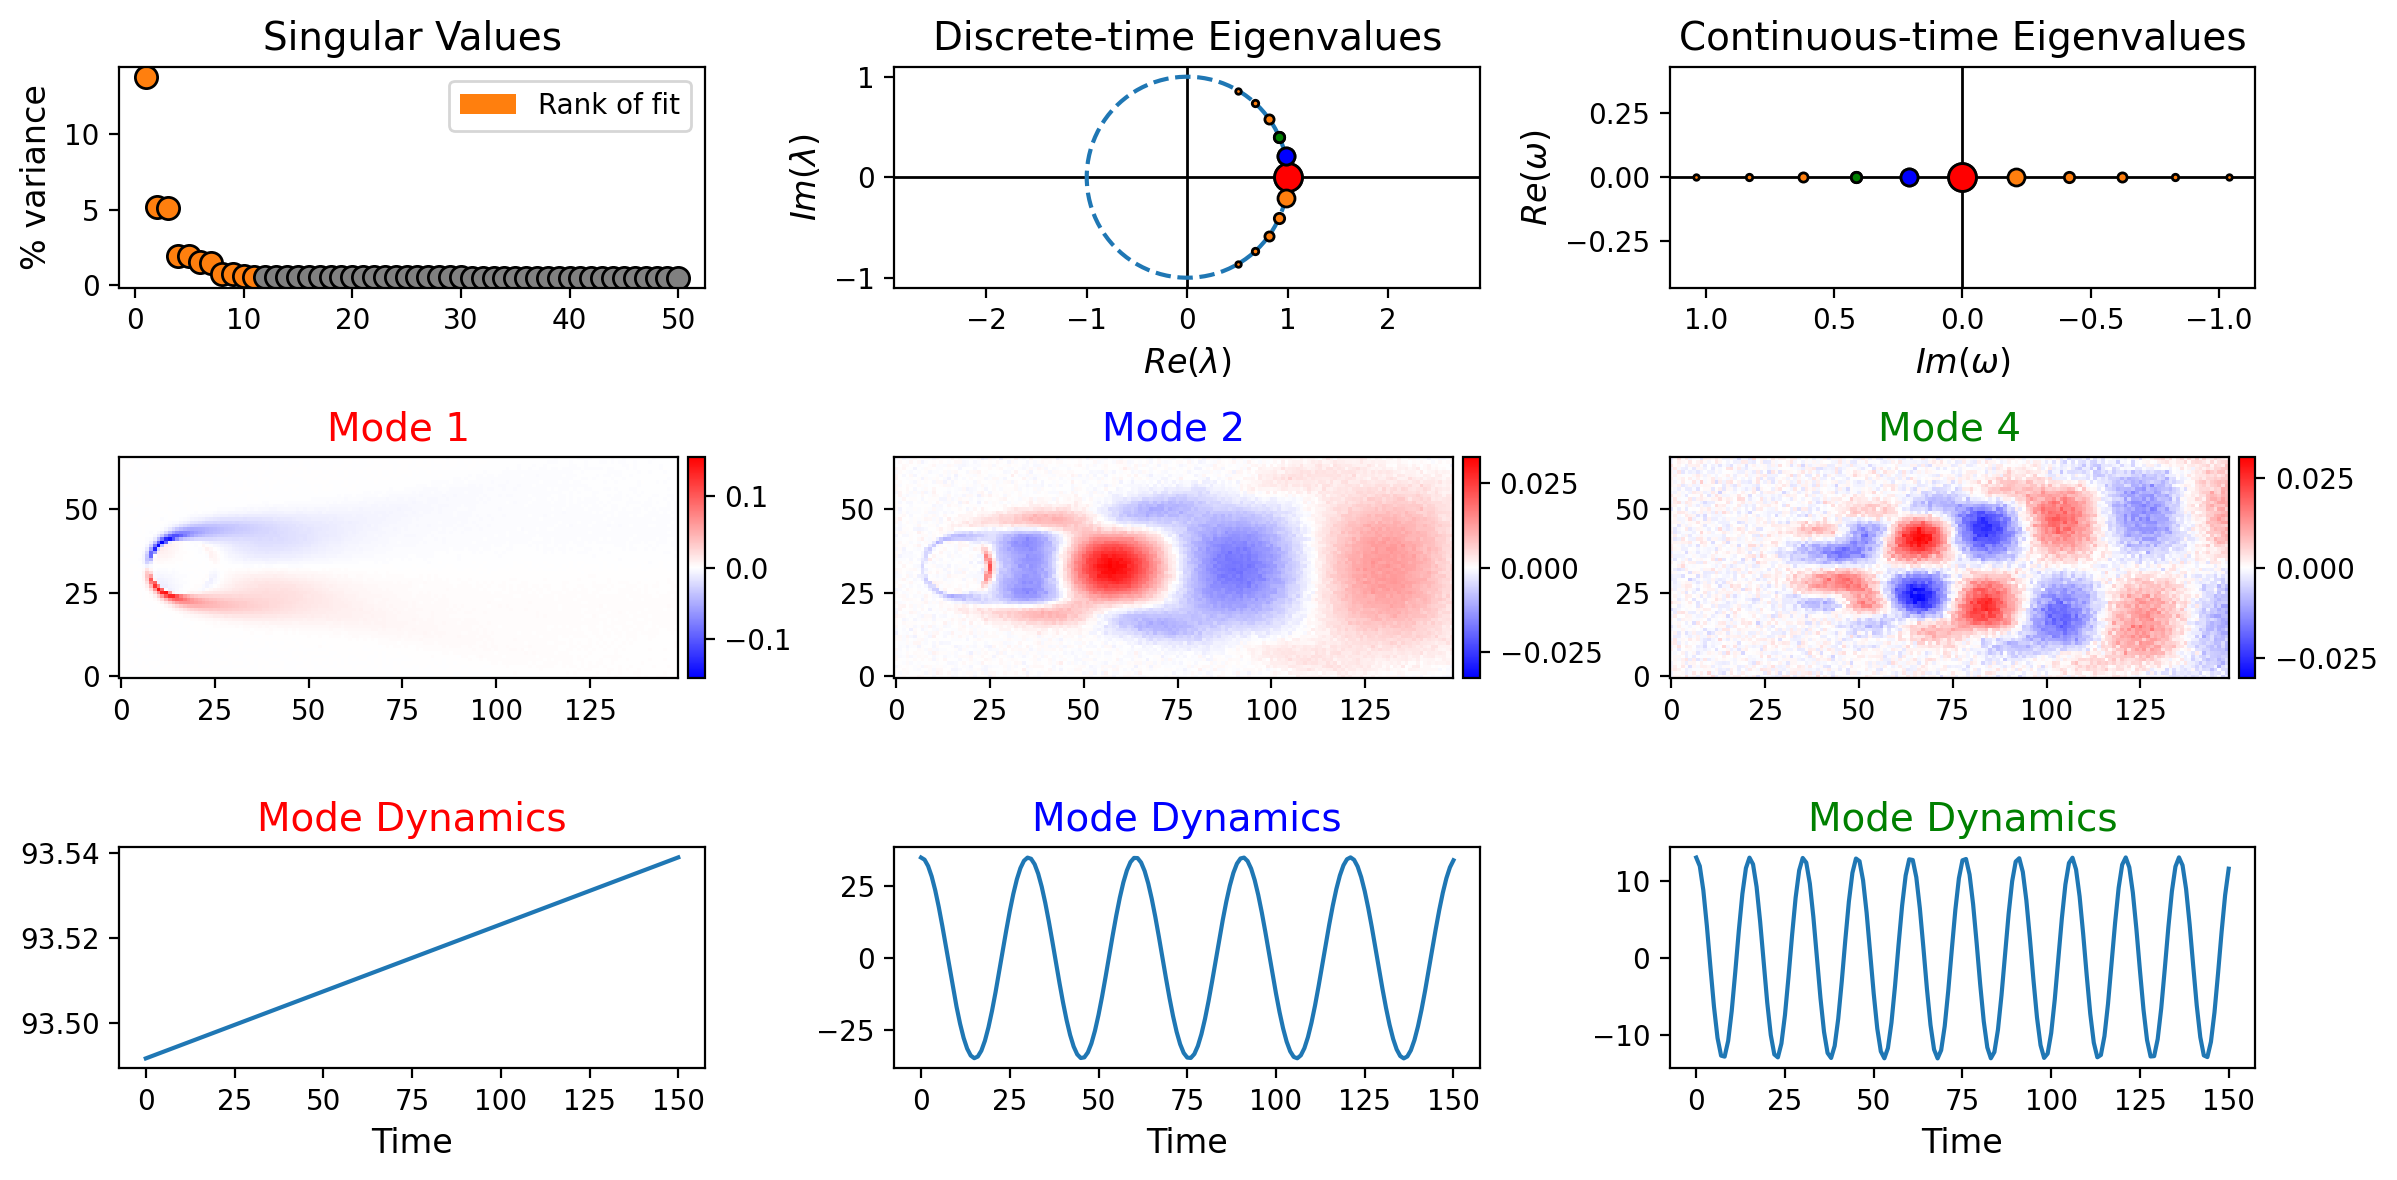

In [14]:
from pydmd.plotter import plot_summary

# Plot a summary of the key spatiotemporal modes.
plot_summary(
    dmd,
    figsize=(12, 6),  # Figure size.
    index_modes=(0, 1, 3),  # Indices of the modes to plot.
    snapshots_shape=(ny, nx),  # Shape of the modes.
    order="F",  # Order to use when reshaping the modes.
    flip_continuous_axes=True,  # Rotate the continuous-time eig plot.
)

### **A more advanced model**

Under the hood, `BOPDMD` is solving nonlinear least-squares optimization problems in order to perform DMD. Because of this, we can tinker with even more attributes of the model:
- Set `num_trials=k` to perform multiple trials of DMD.
- Set `trial_size` to control the amount of data to use per trial.
- Set `eig_constraints` to constrain the eigenvalue structure.

For instance, we might want to constrain our model so that our modes are purely oscillatory, and so that our eigenvalues come in complex conjugate pairs. We might also want to perform multiple trials of the optimization in hopes of obtaining a model that is more accurate. If so, we might build a model like the following:

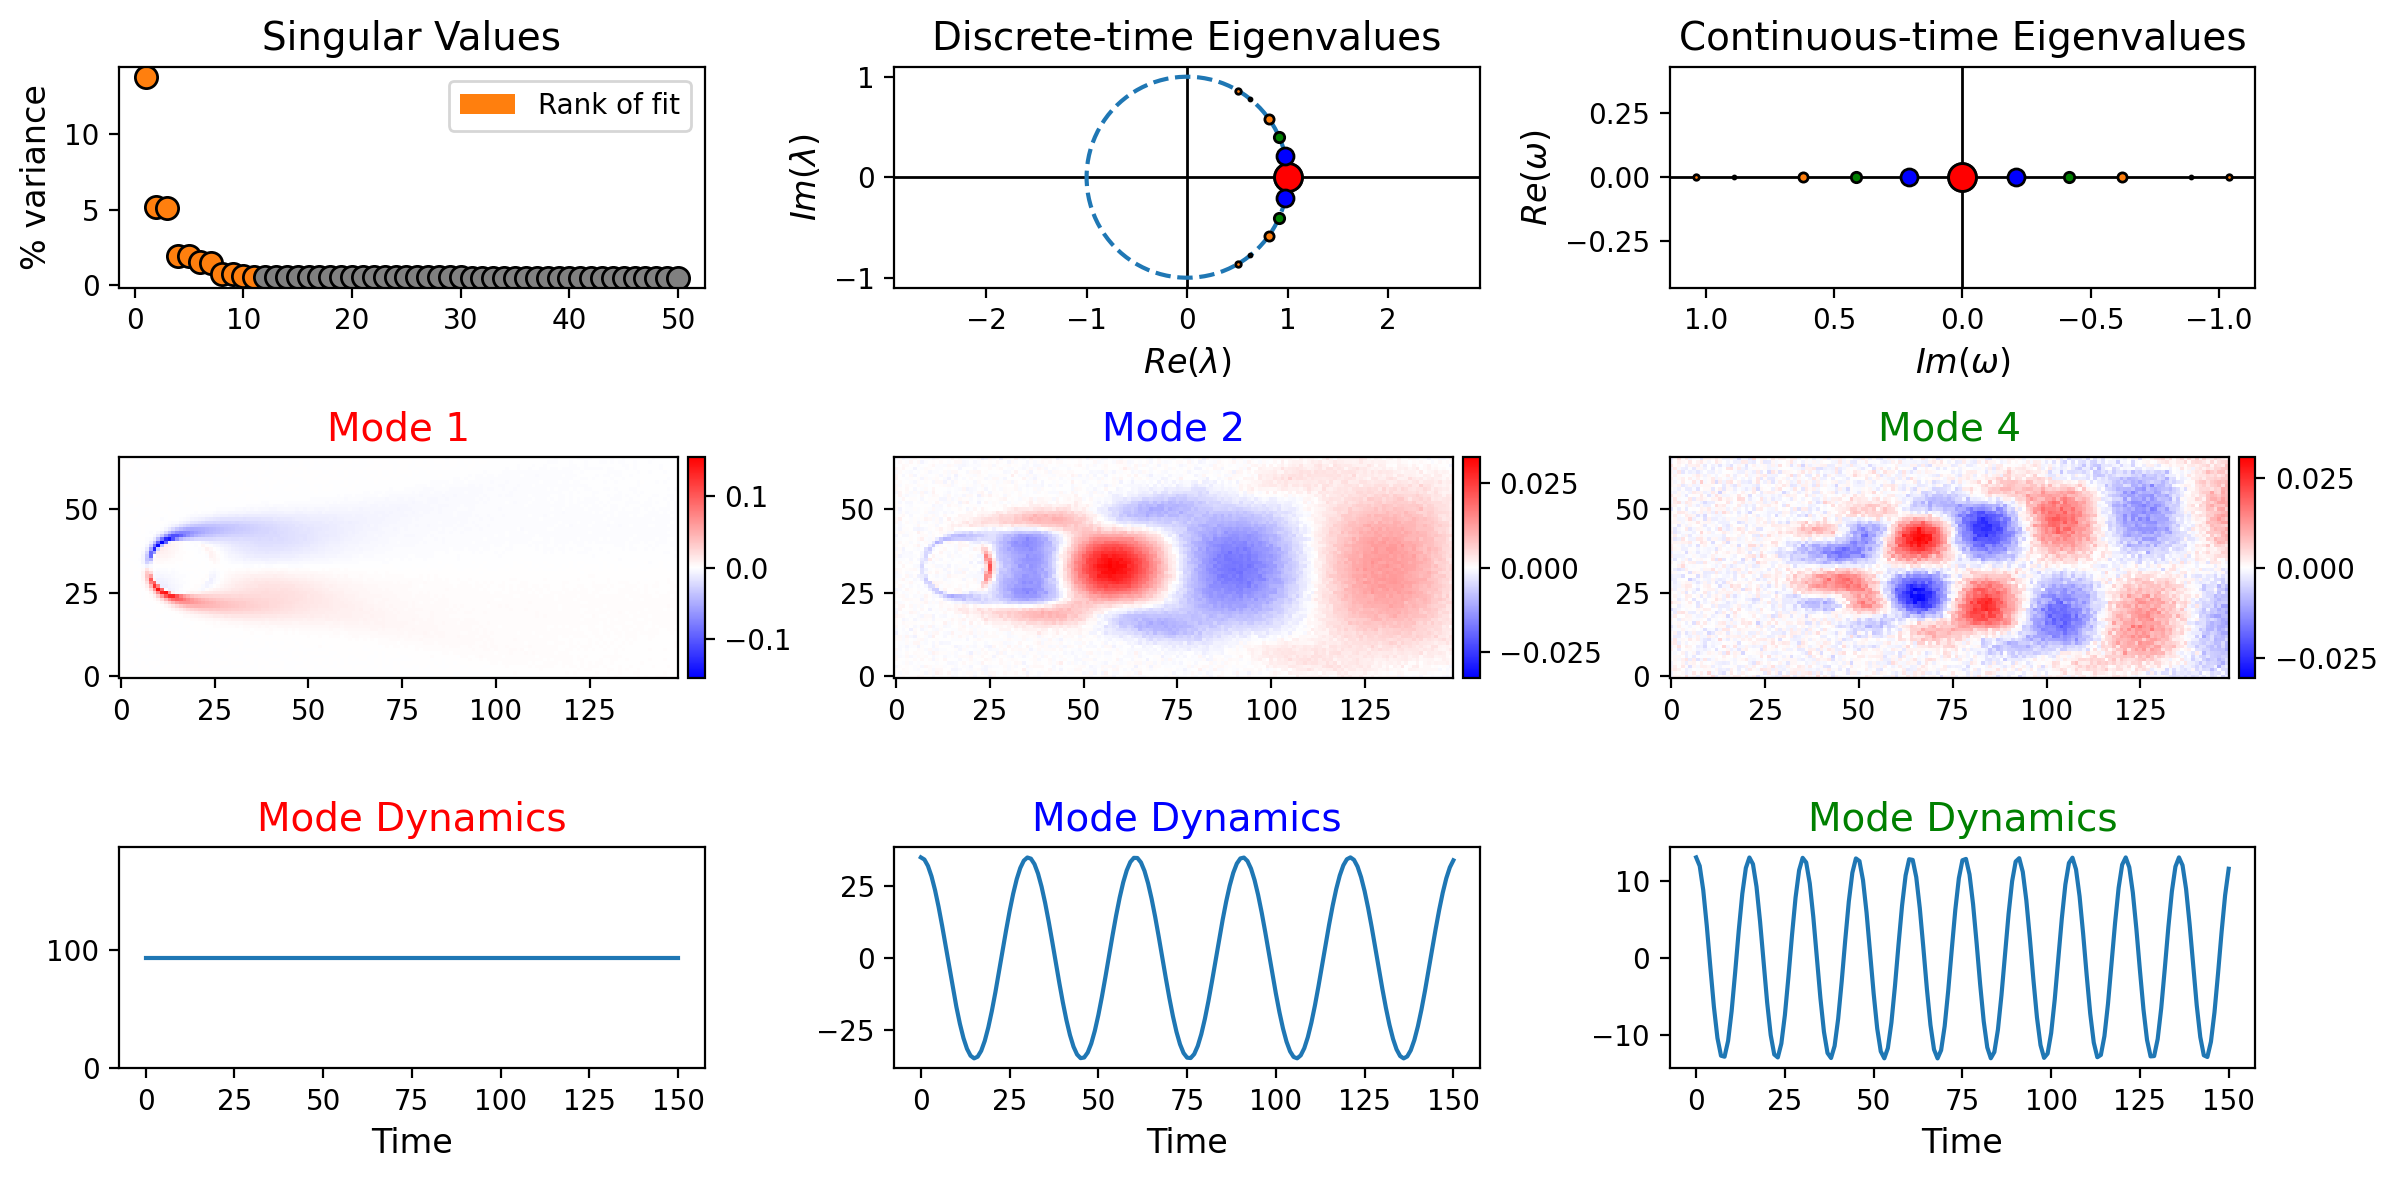

In [15]:
# Build a BOP-DMD model with 11 spatiotemporal modes, and 100 bagging trials,
# where each trial uses 80% of the total number of snapshots per trial.
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    # Constrain the eigenvalues to be imaginary
    # AND to always come in complex conjugate pairs.
    eig_constraints={"imag", "conjugate_pairs"},
)
# Perform the rest of the DMD fitting pipeline:
bopdmd.fit(X, t)
plot_summary(
    bopdmd,
    figsize=(12, 6),
    index_modes=(0, 1, 3),
    snapshots_shape=(ny, nx),
    order="F",
    flip_continuous_axes=True,
)

### **More Resources**
For more information and for more beginner tutorials, check out the following tutorials already in PyDMD. :)
- [PyDMD Tutorial 1](https://github.com/PyDMD/PyDMD/blob/master/tutorials/tutorial1/tutorial-1-dmd.ipynb)
- [BOP-DMD User Manual](https://github.com/PyDMD/PyDMD/blob/master/tutorials/user-manual1/user-manual-bopdmd.ipynb)
- [SIAM UQ24 Minitutorial Session](https://github.com/PyDMD/PyDMD/blob/siamuq24/minitutorials/siamuq24_mt.ipynb)

# Part 2: SINDy

In [16]:
# !pip install pysindy

Lotka–Volterra system data loaded!
X.shape (state, time) = (2, 2501)
t.shape (time,) = (2501,)
Time Discretization: [0.0, 25.0], dt = 0.01


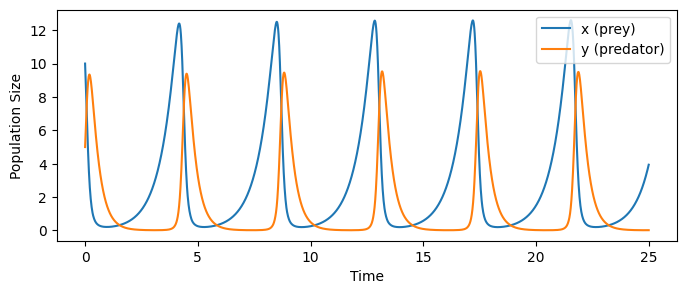

In [17]:
# Load the Lotka–Volterra data.
X = np.load("data/X_lv.npy")
t = np.load("data/t_lv.npy")

print("Lotka–Volterra system data loaded!")
print(f"X.shape (state, time) = {X.shape}")
print(f"t.shape (time,) = {t.shape}")
print(f"Time Discretization: [{t[0]}, {t[-1]}], dt = {np.round(t[1] - t[0], decimals=3)}")

# Plot the time-series data.
plt.figure(figsize=(8, 3))
plt.plot(t, X[0], label="x (prey)")
plt.plot(t, X[1], label="y (predator)")
plt.ylabel("Population Size")
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.show()

In [18]:
import pysindy as ps

# Use second-order centered finite difference to approximate derivatives.
differentiation_method = ps.FiniteDifference(order=2)

# Use polynomials up to degree 3 for the feature library.
feature_library = ps.PolynomialLibrary(degree=3)

# Use sequentially thresholded least for sparse-regression.
optimizer = ps.STLSQ(threshold=0.2)

# Build the SINDy model.
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)

# Fit the SINDy model to our data.
model.fit(X.T, t=t)  # Note: PySINDy takes (time, state) data.
model.print()

(x)' = 1.496 x + -0.999 x y
(y)' = -2.996 y + 0.999 x y


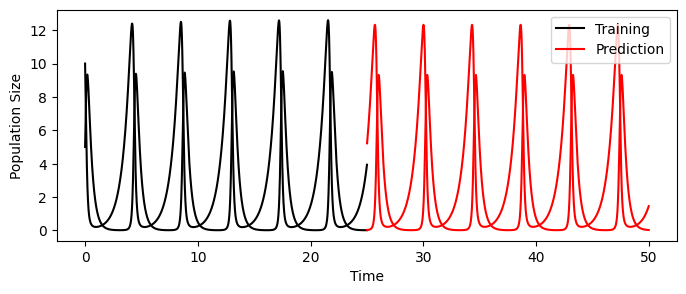

In [19]:
# Compute reconstruction over a longer time span.
t_long = np.arange(0, 50, t[1] - t[0])
X_recon = model.simulate(x0=X[:, 0], t=t_long).T

# Plot the reconstruction.
plt.figure(figsize=(8, 3))
plt.plot(t, X[0], c="k")
plt.plot(t, X[1], c="k", label="Training")
plt.plot(t_long[len(t):], X_recon[0][len(t):], c="r")
plt.plot(t_long[len(t):], X_recon[1][len(t):], c="r", label="Prediction")
plt.ylabel("Population Size")
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.show()

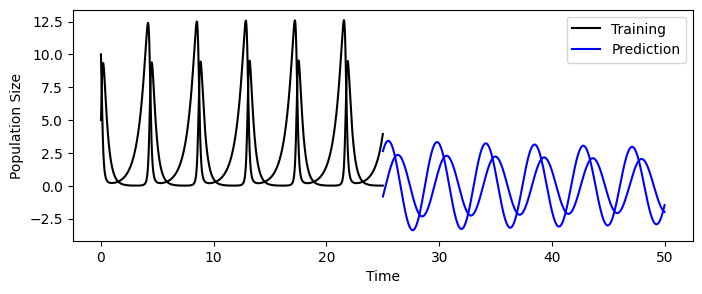

In [20]:
# A linear DMD model cannot model this nonlinear system!
dmd = BOPDMD(svd_rank=2)
dmd.fit(X, t)
X_recon_dmd = dmd.forecast(t_long)

plt.figure(figsize=(8, 3))
plt.plot(t, X[0], c="k")
plt.plot(t, X[1], c="k", label="Training")
plt.plot(t_long[len(t):], X_recon_dmd[0][len(t):], c="b")
plt.plot(t_long[len(t):], X_recon_dmd[1][len(t):], c="b", label="Prediction")
plt.ylabel("Population Size")
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.show()